# Practice 3

Student 1: Alejandro González Álvarez

NIA 1: 252658

Student 2: Luca Franceschi

NIA 2: 253885

Student 3: Júlia Othats-Dalès

NIA 3: 254435

In [1]:
#!pip install torchinfo

In [2]:
import torch
import torchinfo
import torchvision
import numpy as np
from PIL import Image
import torch.nn as nn
import scipy.io as sio
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torchvision.transforms as tf

# Google Drive (or not)

In [6]:
# Comment if not in Google Colab
from google.colab import drive
drive.mount('/content/drive')

datadir = '/content/drive/My Drive/DeepLearning_2024/P3/Data/'
# datadir = 'Data/'

resultsdir = '/content/drive/My Drive/DeepLearning_2024/P3/Results/'
# resultsdir = 'Results/'

Mounted at /content/drive


# GPU Acceleration (or not)

In [7]:
# Print if gpu acceleration is enabled
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cpu device


# **SVHN Dataset**
In the following exercices, you will work with the SVHN dataset: http://ufldl.stanford.edu/housenumbers/

It contains RGB images of street digits labeled from 1 to 10 similar to the MNIST dataset.

The train and test sets are provided in the folder Data/svhn/ in .mat format.
In the following we show an example of how to load the images and labels from these files. A DataLoader for this dataset is provided in the code examples for the lab.

Label: 1


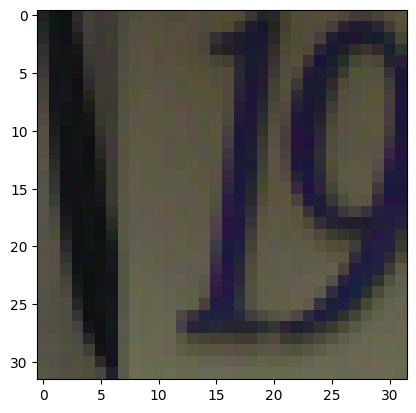

In [8]:
train_mat = sio.loadmat(datadir + 'svhn/train_32x32.mat')

images = train_mat['X']
labels = train_mat['y'].squeeze()

example_image, example_label = images[:,:,:,0], labels[0]
print('Label: ' + str(example_label))
plt.imshow(example_image)
plt.show()

# Ex. 1


1. Try to obtain the maximum test accuracy possible in the SVHN dataset. For this purpose train/test different variants of the CNN provided in P3-Part1-Examples. You can explore different strategies:
    - 1.1. Increase the size of the network by adding one ore more conv. layers. You can also increase the number of filters in each layer.
    - 1.2. Try different optimizers such as Adam or SGD with momentum and modify the learning rate. You can check: https://pytorch.org/docs/stable/optim.html
    - 1.3. Explore different random transformations during training ( Data augmentation ) such as random cropping with padding. You can check: https://pytorch.org/docs/stable/torchvision/transforms.html . Remember that these random transofrmation must not be used during testing.
    - 1.4 Whatever you consider...

2. Save all the different models , compare their test accuracy and analyse the results. Discuss what model has been shown more effective and why have you used the different strategies.

# Sol. 1

## The SVHN Dataset

In [9]:
#Data Loader
class SVHN(torch.utils.data.Dataset):

    def __init__(self, dataDir = datadir + 'svhn/train_32x32.mat', transform = None):
        mat = sio.loadmat(dataDir)
        self.data, self.labels = mat['X'], mat['y'].squeeze()
        self.transform = transform

        # We noticed that 0s were labeled as 10s
        self.labels[self.labels == 10] = 0

    def __getitem__(self, index):
        data = self.data[:,:,:,index]
        lbl = self.labels[index]

        data = Image.fromarray(data)
        # Apply a trasnformaiton to the image if it is indicated in the initalizer
        if self.transform is not None :
            data = self.transform(data)

        # return the image and the lab
        return data,lbl

    def __len__(self):
        return len(self.labels)

def mean_std(dataDir= datadir + 'svhn/train_32x32.mat'):
    mat = sio.loadmat(dataDir)
    data = mat['X']
    return data.mean(axis=(0,1,3)) / 255, data.std(axis=(0,1,3)) / 255

In [10]:
SVHN_mean, SVHN_std = mean_std()
print('Normalized dataset mean by channel', SVHN_mean)
print('Normalized dataset standard deviation by channel', SVHN_std)

tr = tf.Compose([
    tf.ToTensor(),
    tf.Normalize(mean = SVHN_mean, std = SVHN_std)
])

# Load train and test datasets
SVHNTrain = SVHN(datadir + 'svhn/train_32x32.mat', tr)
train_loader = torch.utils.data.DataLoader(dataset=SVHNTrain,
                                            batch_size=256,
                                            shuffle=True)

SVHNTest = SVHN(datadir + 'svhn/test_32x32.mat',tr)
test_loader = torch.utils.data.DataLoader(dataset=SVHNTest,
                                            batch_size=256,
                                            shuffle=True)

Normalized dataset mean by channel [0.4376821  0.4437697  0.47280442]
Normalized dataset standard deviation by channel [0.19803012 0.20101562 0.19703614]


In [11]:
total_step = len(SVHNTrain)
print(f'There are {total_step} samples in the training dataset')
print(f'There are {len(SVHNTest)} samples in the test dataset')

There are 73257 samples in the training dataset
There are 26032 samples in the test dataset


## ConvNet class

In [12]:
# Define an standard CNN -> Two conv. blocks and linear layer
class ConvNet(nn.Module):
    def __init__(self, num_classes=10):

        super(ConvNet, self).__init__()

        self.conv1 = nn.Conv2d(3, 16, kernel_size=5,  padding=2)
        #input : 3 channel, output 16 channel, filter size : 5x5

        self.conv2 = nn.Conv2d(16, 32, kernel_size=3,  padding=1)
        #input : 16 channel, output 32 channel, filter size : 3x3

        self.fc = nn.Linear(8*8*32, num_classes)

        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.relu = nn.ReLU()

    def forward(self, x):

        out = self.conv1(x)
        out = self.relu(out)
        out = self.maxpool(out)

        out = self.conv2(out)
        out = self.relu(out)
        out = self.maxpool(out)

        out = out.reshape(out.size(0), -1) #128,64,2,2 -> 128,2*2*64
        out = self.fc(out) # we don't need sigmoid or other activation function at the end beacuse we will use nn.CrossEntropyLoss() (check documentation to understand why)

        return out

## Training and Testing functions

In [26]:
# Train function
def train(CNN, train_loader, optimizer, num_epochs=5, model_name='model.ckpt'):
    CNN.train() # Set the model in train mode
    losses_list = []
    criterion = nn.CrossEntropyLoss()
    # Iterate over epochs
    for epoch in range(num_epochs):
        # Iterate the dataset
        loss_sum = 0
        for images, labels in train_loader:
            # Get batch of samples and labels
            images = images.to(device)
            labels = labels.type(torch.LongTensor).to(device)

            # Forward pass
            outputs = CNN(images)
            loss = criterion(outputs, labels)

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            loss_sum += loss.cpu().item()
            losses_list.append(loss.cpu().item())

        loss_avg = loss_sum / len(train_loader)
        print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, loss_avg))

        # Save the model checkpoint
        torch.save(CNN.state_dict(), resultsdir + '/' + model_name)

    return losses_list

# Test funcion
def test(CNN, test_loader):
    CNN.eval() # Set the model in evaluation mode
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            # get network predictions
            outputs = CNN(images)

            # get predicted class
            _, predicted = torch.max(outputs.data, 1)

            # compare with the ground-truth
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        # print and return accuracy
        print('Test Accuracy of the model on the 10000 test images: {} %'.format(100 * correct / total))
        return 100 * correct / total

def plot_loss(losses_list):
    plt.figure(figsize=(10, 5))
    plt.plot(losses_list, linestyle='-', color='b')
    plt.title('Training Loss Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.show()

In [29]:
CNN = ConvNet().to(device)

#Initialize optimizer
learning_rate = .001
optimizer = torch.optim.Adam(CNN.parameters(),lr = learning_rate)

num_epochs = 5

Epoch [1/5], Loss: 1.0258
Epoch [2/5], Loss: 0.5364
Epoch [3/5], Loss: 0.4747
Epoch [4/5], Loss: 0.4310
Epoch [5/5], Loss: 0.3998


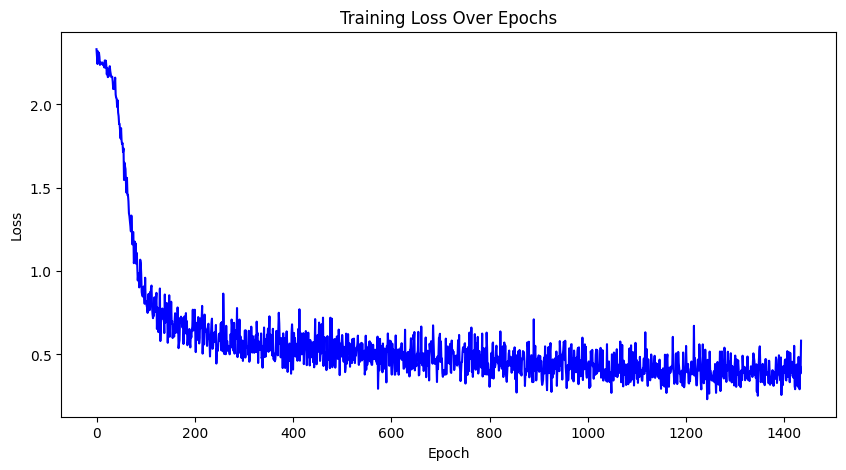

Test Accuracy of the model on the 10000 test images: 86.82390903503381 %


In [30]:
loss_list = train(CNN, train_loader, optimizer, num_epochs, model_name='model_1_1.ckpt')
plot_loss(loss_list)

CNN.load_state_dict(torch.load(resultsdir + 'model_1_1.ckpt'))

test_acc = test(CNN, test_loader)

## Testing with different changes


#### Number of convolution layers and number of filters (channels)

In [31]:
#Increasing size of network (one more conv layer)
class TestingConvNet(nn.Module):
    def __init__(self, num_classes=10):

        super(TestingConvNet, self).__init__()

        self.conv1 = nn.Conv2d(3, 16, kernel_size=5,  padding=2)
        #input : 3 channel, output 16 channel, filter size : 5x5

        self.conv2 = nn.Conv2d(16, 32, kernel_size=3,  padding=1)
        #input : 16 channel, output 32 channel, filter size : 3x3

        self.conv3 = nn.Conv2d(32, 64, kernel_size=5,  padding=2) # (8 + 2*2 - 5)/1 + 1 = 8
        #input : 32 channel, output 64 channel, filter size : 5x5

        self.conv4 = nn.Conv2d(64, 128, kernel_size=3,  padding=1) # (4 + 2*1 - 3)/1 + 1 = 4
        #input : 64 channel, output 128 channel, filter size : 3x3

        self.fc = nn.Linear(8*8*8, num_classes)

        self.maxpool= nn.MaxPool2d(kernel_size=2, stride=2)
        self.relu = nn.ReLU()

    def forward(self, x):

        out = self.conv1(x)
        out = self.relu(out)
        out = self.maxpool(out)

        out = self.conv2(out)
        out = self.relu(out)
        out = self.maxpool(out)

        out = self.conv3(out)
        out = self.relu(out)
        out = self.maxpool(out)

        out = self.conv4(out)
        out = self.relu(out)
        out = self.maxpool(out)

        out = out.reshape(out.size(0), -1) #128,64,2,2 -> 128,2*2*64
        out = self.fc(out) # we don't need sigmoid or other activation function at the end beacuse we will use nn.CrossEntropyLoss() (check documentation to understand why)

        return out

In [32]:
CNN = TestingConvNet().to(device)

#Initialize optimizer
learning_rate = .001
optimizer = torch.optim.Adam(CNN.parameters(),lr = learning_rate)

num_epochs = 5

Epoch [1/5], Loss: 1.0730
Epoch [2/5], Loss: 0.4392
Epoch [3/5], Loss: 0.3474
Epoch [4/5], Loss: 0.2900
Epoch [5/5], Loss: 0.2510


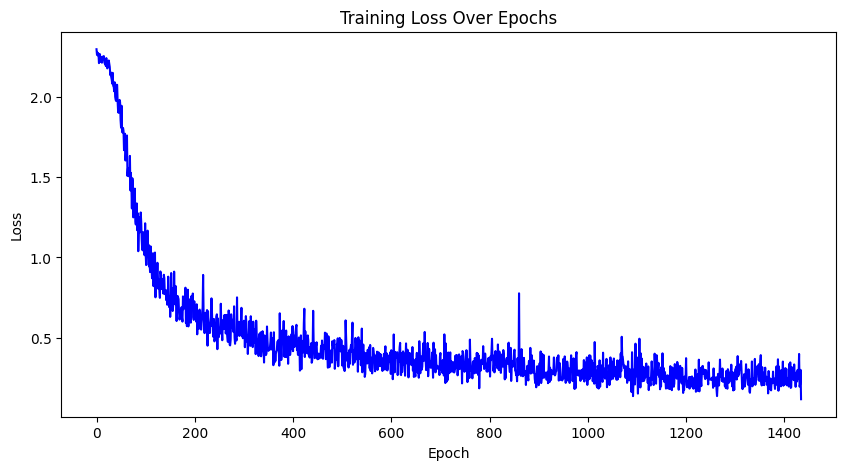

Test Accuracy of the model on the 10000 test images: 90.9380762138906 %


In [33]:
loss_list = train(CNN, train_loader, optimizer, num_epochs, model_name='model_1_2.ckpt')
plot_loss(loss_list)

CNN.load_state_dict(torch.load(resultsdir + 'model_1_2.ckpt'))

test_acc = test(CNN, test_loader)

#### Optimizers

In [ ]:
CNN = ConvNet().to(device)

optimizers = [(torch.optim.Adam(CNN.parameters(),lr = .001), "Adam"),
              (torch.optim.SGD(CNN.parameters(), lr = .001, momentum = 0.9), "SGD")]

num_epochs = 5

In [ ]:
for optimizer, label in optimizers:

    train(CNN, train_loader, optimizer, num_epochs, model_name='model_1_' + label + '.ckpt')

    CNN.load_state_dict(torch.load(resultsdir + 'model_1_' + label + '.ckpt'))

    test_acc = test(CNN, test_loader)

#### Learning rate


In [ ]:
CNN = ConvNet().to(device)

learning_rates = [.01, .05, .001, .005, .0001]

num_epochs = 5

In [ ]:
for i, lr in enumerate(learning_rates):
    train(CNN, train_loader, optimizer, num_epochs, model_name='model_1_' + str(i) + '.ckpt')

    CNN.load_state_dict(torch.load(resultsdir + 'model_1_lr' + str(i) + '.ckpt'))

    test_acc = test(CNN, test_loader)

# Ex. 2

## **Building your own efficient Convolutional Network architecture for SVHN**

In the following,  you will need to build your own CNN architecture to predict digit numbers on the SVHN dataset. You are completely free to use any kind of layers and hyper-parameters for this purpose. Your goal is to acheive the maximum possible accuracy on the test set (the better, the higher score you'll get in the exercice). The only constraint is that your model should not contain more than 150K parameters. Below, we provide a simple code to compute the number of parameters in a model.

## Computing model parameters

In [ ]:
# Compute model paramters
def compute_model_params(model):
  params = 0
  for p in model.parameters():
    params+= p.numel()
  return params

In [ ]:
'''
1. Design and implement your own CNN. Given that the number of parameters must be small, you can check some papers focused on efficient CNN architectures and get some ideas.
  - MobileNet: https://arxiv.org/abs/1704.04861
  - MobileNet V2: https://arxiv.org/pdf/1801.04381.pdf
  - SqueezeNet: https://arxiv.org/abs/1602.07360
  - ShuffleNet: https://arxiv.org/abs/1707.01083
  - ESPNet V2: https://arxiv.org/abs/1811.11431
2. Train it and test it on SVHN using the provided code.
3. Discuss what approaches have you tried, why, and which ones have shown to be more beneficial.
'''


# Sol. 2

## Define your own model and check the number of total parameters

In [ ]:
# We are trying to implement a SqueezeNet-like architecture using the fire module extracted from
# https://github.com/xin-w8023/SqueezeNet-PyTorch/blob/master/fire.py

class Expand(torch.nn.Module):
    def __init__(self, in_channels, e1_out_channles, e3_out_channles):
        super(Expand, self).__init__()
        self.conv_1x1 = torch.nn.Conv2d(in_channels, e1_out_channles, (1, 1))
        self.conv_3x3 = torch.nn.Conv2d(in_channels, e3_out_channles, (3, 3), padding=1)

    def forward(self, x):
        o1 = self.conv_1x1(x)
        o3 = self.conv_3x3(x)
        return torch.cat((o1, o3), dim=1)


class Fire(torch.nn.Module):
    """
      Fire module in SqueezeNet
      out_channles = e1x1 + e3x3
      Eg.: input: ?xin_channelsx?x?
           output: ?x(e1x1+e3x3)x?x?
    """
    def __init__(self, in_channels, s1x1, e1x1, e3x3):
        super(Fire, self).__init__()

        # squeeze
        self.squeeze = torch.nn.Conv2d(in_channels, s1x1, (1, 1))
        self.sq_act = torch.nn.LeakyReLU(0.1)

        # expand
        self.expand = Expand(s1x1, e1x1, e3x3)
        self.ex_act = torch.nn.LeakyReLU(0.1)


    def forward(self, x):
        x = self.sq_act(self.squeeze(x))
        x = self.ex_act(self.expand(x))
        return x

In [ ]:
# ESPNet V2 Style Architecture
class MyModel(nn.Module):
    def __init__(self, num_classes=10):

        super(MyModel, self).__init__()
        self.conv1 = nn.Conv2d(3, 8, kernel_size=3, stride=1, padding=1)
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fire1 = Fire(8, 4, 8, 8)
        self.fire2 = Fire(16, 8, 8, 8)
        self.fire3 = Fire(16, 8, 16, 16)
        self.fire4 = Fire(32, 16, 32, 32)
        self.fc = nn.Linear(64*8*8, num_classes)

        self.relu = nn.ReLU()

    def forward(self, x):
        out = self.conv1(x)
        out = self.relu(out)

        out = self.fire1(out)
        out = self.fire2(out)
        out = self.maxpool(out)

        out = self.fire3(out)
        out = self.fire4(out)
        out = self.maxpool(out)

        out = self.fc(out.view(out.shape[0], -1))
        return out

model = MyModel(num_classes=10)
n_params = compute_model_params(model)
print("MyModel Parameters: " + str(n_params))

In [ ]:
torchinfo.summary(model, (1, 3, 32, 32))

## Train your model on SVHN
It is not allowed to change training hyper-parameters such as learning rate, batch size or number of epochs. You can only modify the architecture definition.

In [ ]:
print(len(iter(train_loader))) # me cago en su puta madre no se por que no sale 3

In [ ]:
#Train MyModel
my_model = MyModel().to(device)

#Initialize optimizer
learning_rate = .01
optimizer = torch.optim.SGD(my_model.parameters(),lr = learning_rate,
                            weight_decay=1e-5, momentum=0.9)

In [ ]:
train(CNN, train_loader, optimizer, num_epochs=5, model_name='model_2_1.ckpt')

CNN.load_state_dict(torch.load(resultsdir + 'model_2_1.ckpt'))

## Test your model
As a reference, 93% of accuracy can be easily achieved by using only ~55000 parameters.

In [ ]:
test_acc = test(CNN, test_loader)

# Ex. 3

In [ ]:
'''
1. Use the implemented architecture in the previous exercice to solve the transfer learning
   task provided in the examples.
2. Try to fine-tune not only the last layer for the CNN but a larger subset of parameters.
2. Report the test accuracy in each case and discuss the results.
'''

# Sol. 3

## Initialize DataLoaders for Transfer Learning experiment

In [ ]:
# Big dataset with numbers from 1 to 8
SVHNTrain_TL = SVHN(datadir+'/svhn_tl/tl_train_32x32.mat',tr)
tl_train_loader = torch.utils.data.DataLoader(dataset=SVHNTrain_TL,
                                               batch_size=256,
                                               shuffle=True)

# 200 samples of 0s and 9s
SVHNTrain_TL_0_9 = SVHN(datadir+'/svhn_tl/tl_train_9_10_32x32.mat',tr)
tl_train_loader_0_9 = torch.utils.data.DataLoader(dataset=SVHNTrain_TL_0_9,
                                                  batch_size=64,
                                                  shuffle=True)
# Test dataset with 0 and 9s
SVHNTest_TL_0_9 = SVHN(datadir+'/svhn_tl/tl_test_9_10_32x32.mat',tr)
tl_test_loader_0_9 = torch.utils.data.DataLoader(dataset=SVHNTest_TL_0_9,
                                                  batch_size=64,
                                                  shuffle=True)

## Pre-train your model with the big dataset with numbers from 1 to 8

In [ ]:
#Train ResNet
resnet_tl = MyModel(num_classes=8)
#Initialize optimizer
learning_rate = .1
optimizer = torch.optim.SGD(resnet_tl.parameters(),lr = learning_rate, weight_decay=1e-5, momentum=0.9)

resnet_tl = resnet_tl.to(device)

losses_it = train(resnet_tl, tl_train_loader, optimizer, num_epochs=10, model_name='tl_mynet_svhn.ckpt', device=device)

## Fine-tune the pretrained network with the small dataset of 9s and 0s